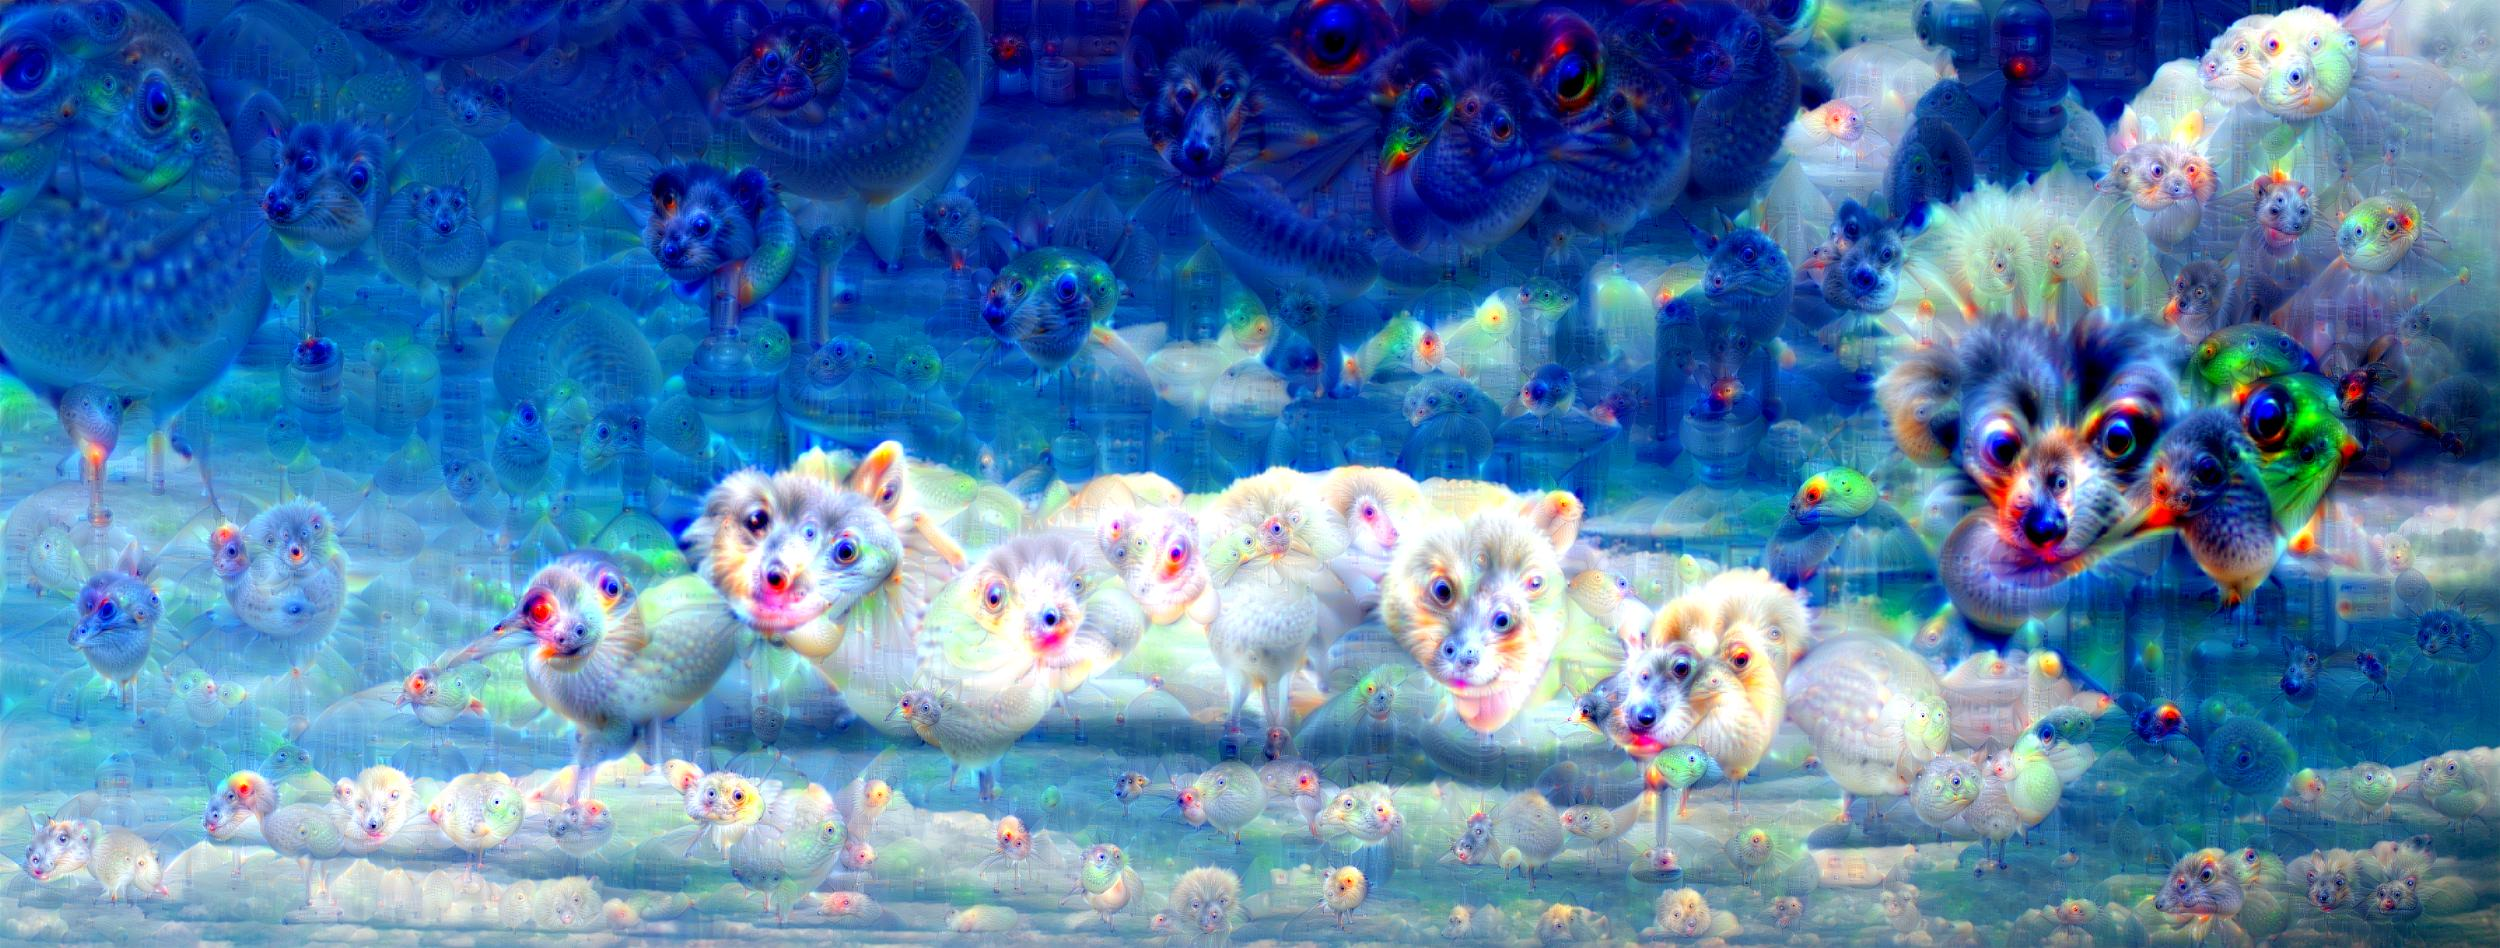

# **DeepDream - Apresentação e implementação (com Pytorch)**

Este notebook tem como objetivo apresentar o DeepDream, a técnica para fazer redes neurais "sonharem", gerando imagens psicodélicas muito interessantes e surreais.

Autor: Paulo Sestini - Grupo Turing da USP


### *Referências*
Os seguintes links, com explicações e códigos, foram utilizados na construção deste notebook.

*Publicação da DeepDream - https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html*

*Jupyter Notebook da DeepDream - https://github.com/google/deepdream*

*Implementação de DeepDream em Pytorch - https://github.com/eriklindernoren/PyTorch-Deep-Dream*

## **O que é o DeepDream?**

O DeepDream, técnica criada pelo engenheiro da Google Alexander Mordvintsev e publicada em 2015, consiste em utilizar redes neurais para alterar imagens e torná-las psicodélicas, com diversos desenhos de animais e objetos surreais.

As redes neurais utilizadas são previamente treinadas para a tarefa de classificação e detecção de padrões em imagens (animais, pessoas, objetos, etc)

Mas como isso torna possível a criação dessas imagens?



## **Detecção de padrões em redes neurais convolucionais**

As redes neurais convolucionais são especializadas em detectar padrões em imagens. Estas redes possuem diversas camadas, e as camadas inicias são responsáveis por detectar padrões simples, como bordas e formas geométricas, enquanto as camadas finais conseguem reconhecer padrões complexos, como cachorros, gatos e pessoas em uma imagem.

Utilizando essa capacidade de cada camada da rede responder a um tipo de padrão, é possível mostrarmos uma imagem para a rede e pedir para ela reforçar os padrões que ela enxerga. Por exemplo, se a rede vê uma forma redonda em uma imagem, ela pode reconhecer esta forma como algo semelhante a um olho, e dessa maneira, podemos fazer com ela reforce esse padrão e faça um olho surgir no local. Esta simples ideia pode se estender para figuras mais complexas, como animais e objetos maiores.




# **Importando bibliotecas e rede pré treinada**

Iremos utilizar a rede VGG-19 pré-treinada, disponível na colêtanea de modelos da biblioteca Pytorch.

In [1]:
# Importando bibliotecas
import torchvision.models as models
from torchvision import transforms
from PIL import Image 
import torch
import numpy as np 
import scipy.ndimage as nd
import IPython

In [2]:
# Definindo onde o pytorch fará suas operações. Caso disponível, a GPU será utilizada
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Importando a rede pré-treinada
net = models.vgg19(pretrained=True).to(device)

# Vamos visualizar a rede
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [3]:
# Precisamos escolher uma camada onde iremos reforçar os padrões enxergados.
# Iremos escolher a camada 27, que está bem profunda na rede, o que
# indica que ela pode ser capaz de reconhecer formas complexas, como animais, o que
# irá gerar imagens bem interessantes

layers = list(net.features.children())
model = torch.nn.Sequential(*layers[:28])
                            
# Visualizando nosso modelo
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# **Funções auxiliares**
Agora iremos definir algumas funções para nos ajudar com a leitura, escrita e processamento de imagens.

In [4]:
def read_image(path):
    """
    Lê uma imagem utilizando a biblioteca PIL
    """
    return Image.open(path)

def preprocess(image):
    """
    Recebe uma imagem em objeto PIL e a processa
    """
    image = transforms.ToTensor()(image)
    mean, std = image.mean(), image.std()

    # Normaliza a imagem e adiciona uma dimensão extra (dimensão necessaria para entrar na rede neural)
    image = transforms.Normalize(mean, std)(image).unsqueeze(0)
    return image, mean, std

def deprocess(image, mean, std):
    """
    Desfaz a normalização do preprocessamento da função preprocess()
    """
    return image*std+mean

def save_tensor_as_image(image_tensor, path):
    image = transforms.ToPILImage()(image_tensor)
    image.save(path)

def show_tensor_as_image(image_tensor):
    image = transforms.ToPILImage()(image_tensor)
    IPython.display.display(image)

# **Realizando o DeepDream**

Como queremos reforçar um padrão visto pela rede, precisamos alterar nossa imagem de modo que as ativações na rede para os padrões observados sejam maximizados. Dessa forma, iremos maximizar a norma(módulo) das ativações da saída do nosso modelo, ajustando nossa imagem de entrada por meio do processo de gradiente ascendente.

In [5]:
# Processo de deep dream
def dream_step(image, model, iters, step):
    image = image.to(device)
    image.requires_grad=True # Indica para o pytorch armazenar os gradientes da imagem

    for i in range(iters):
        print(f"Percentage: {100*i/iters:.2f}%")
        
        output = model(image)

        # Gradiente ascendente com gradiente normalizado
        norm = torch.norm(output)
        norm.backward()
        image.data += step*image.grad.data/torch.norm(image.grad.data)
        image.grad.data.zero_()
    print("Done!")
    return image.detach().cpu()

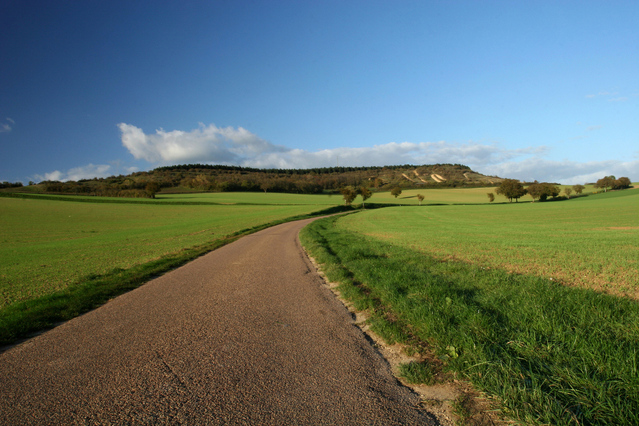

In [16]:
# Imagem que será utilizada
image = read_image("landscape.jpg")
IPython.display.display(image)

In [17]:
# Aplicando o DeepDream
image, mean, std = preprocess(image)
dreamed_image = dream_step(image, model, iters=10, step=100)[0]
dreamed_image = deprocess(dreamed_image, mean, std)

# Após o processo, podemos ter pixels com intensidades maiores ou menores do que o permitido
# (a imagem pode ter ficado "estourada"), por isso, iremos realizar um clipping
dreamed_image = torch.clamp(dreamed_image, 0, 1)

save_tensor_as_image(dreamed_image, "dreamed1.jpg")

Percentage: 0.00%
Percentage: 10.00%
Percentage: 20.00%
Percentage: 30.00%
Percentage: 40.00%
Percentage: 50.00%
Percentage: 60.00%
Percentage: 70.00%
Percentage: 80.00%
Percentage: 90.00%
Done!


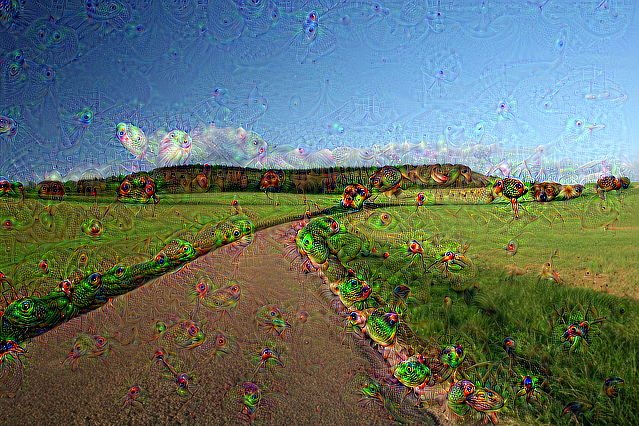

In [18]:
show_tensor_as_image(dreamed_image)

Vemos que vários padrões interessantes surgiram, é possível ver a aparição de diversas formas que se assemelham a animais e construções.

Porém, os padrões ainda são muito pequenos, devido à grande resolução da imagem, a rede tende a reforçar pequenos padrões locais.

Para contornar este problema, iremos implementar outra função de DeepDream, mas
que desta vez irá realizar zooms (scalings) nas imagens para amplificar o efeito
da rede.

In [9]:
def dream(image, model, iters, step, scaling, num_scalings):
    image = image.cpu().data.numpy()

    # Gerando scalings
    scalings = [image]
    for _ in range(num_scalings-1):
        scalings.append(nd.zoom(scalings[-1], (1, 1, 1/scaling, 1/scaling), order=1))

    # Array que irá armazenar os padrões reforçados pela rede
    net_patterns = np.zeros_like(scalings[-1])
    
    for i, scaling in enumerate(scalings[::-1]):
        print(f"Scaling {i}")
        # Para zooms que não sejam a imagem no tamanho original, aplicamos um scaling
        # no array de padrões
        if i > 0:
            net_patterns = nd.zoom(net_patterns, np.array(scaling.shape) / np.array(net_patterns.shape), order=1)

        # A imagem de entrada será duas parcelas, o scaling e o array para a rede armazenar
        # os padrões
        input_image = torch.Tensor(scaling + net_patterns)
        dreamed = dream_step(input_image, model, iters, step).detach().cpu()

        # Ficamos apenas com os padrões reforçados pela rede, para serem usados no DeepDream do próximo scaling
        net_patterns = dreamed - scaling
    
    return dreamed

In [14]:
# Aplicando o DeepDream
image = read_image("landscape.jpg")
image, mean, std = preprocess(image)

# Nova função
dreamed_image = dream(image, model, iters=20, step=10, scaling=1.4, num_scalings=4)[0]

dreamed_image = deprocess(dreamed_image, mean, std)
dreamed_image = torch.clamp(dreamed_image, 0, 1)
save_tensor_as_image(dreamed_image, "dreamed2.jpg")

Scaling 0
Percentage: 0.00%
Percentage: 5.00%
Percentage: 10.00%
Percentage: 15.00%
Percentage: 20.00%
Percentage: 25.00%
Percentage: 30.00%
Percentage: 35.00%
Percentage: 40.00%
Percentage: 45.00%
Percentage: 50.00%
Percentage: 55.00%
Percentage: 60.00%
Percentage: 65.00%
Percentage: 70.00%
Percentage: 75.00%
Percentage: 80.00%
Percentage: 85.00%
Percentage: 90.00%
Percentage: 95.00%
Done!
Scaling 1
Percentage: 0.00%
Percentage: 5.00%
Percentage: 10.00%
Percentage: 15.00%
Percentage: 20.00%
Percentage: 25.00%
Percentage: 30.00%
Percentage: 35.00%
Percentage: 40.00%
Percentage: 45.00%
Percentage: 50.00%
Percentage: 55.00%
Percentage: 60.00%
Percentage: 65.00%
Percentage: 70.00%
Percentage: 75.00%
Percentage: 80.00%
Percentage: 85.00%
Percentage: 90.00%
Percentage: 95.00%
Done!
Scaling 2
Percentage: 0.00%
Percentage: 5.00%
Percentage: 10.00%
Percentage: 15.00%
Percentage: 20.00%
Percentage: 25.00%
Percentage: 30.00%
Percentage: 35.00%
Percentage: 40.00%
Percentage: 45.00%
Percentage: 50

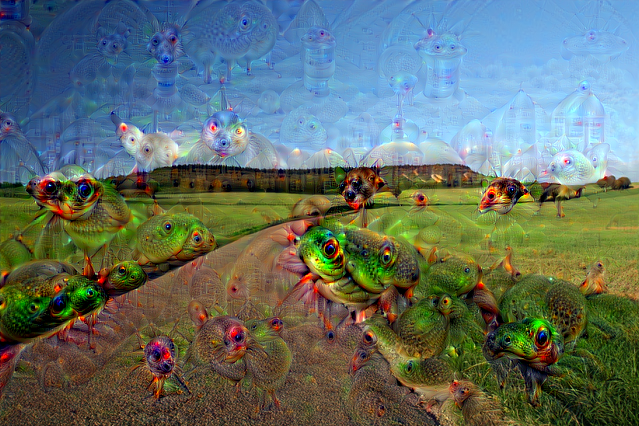

In [15]:
show_tensor_as_image(dreamed_image)

Agora sim, obtemos resultados bem impressionantes. Vemos animais e construções bem mais definidos.

Sinta-se livre para rodar uma imagem à sua escolha. Recomenda-se o uso de uma GPU para acelerar o processamento.